In [1]:
!pip install opencv-python

In [1]:
import cv2
from IPython.display import Image, display
import matplotlib.pyplot as plt
import os
import pytesseract
import numpy as np
import re

In [3]:
def is_blurry(image, threshold=100):
    """Returns True if image is blurry."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lap_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    return lap_var < threshold

# Habilitar camara
camera = cv2.VideoCapture(0)

# Alta resolucion
camera.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
camera.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

if not camera.isOpened():
    print("❌ Error: No se puede abrir la cámara web.")
else:
    print("📸 Cámara lista. Alinea tu identificación dentro del recuadro verde..")
    print("💡 Tips: Mantenga la identificación plana, firme y bien iluminada..")
    print("Presione 's' para capturar, o 'q' para salir.")

    while True:
        ret, frame = camera.read()
        if not ret:
            print("❌ No se pudo capturar el marcoe.")
            break

        # Dimensiones de cuadro
        h, w, _ = frame.shape

        # Dimensiones de cuadro guia
        box_width, box_height = 600, 360
        x1 = w // 2 - box_width // 2
        y1 = h // 2 - box_height // 2
        x2 = w // 2 + box_width // 2
        y2 = h // 2 + box_height // 2

        # Resalte de cuadro verde guia
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Preview
        cv2.imshow("Alinear ID en cuadro verde - Presionar 's' para guardar", frame)

        key = cv2.waitKey(1)
        if key == ord('s'):
            # Cropping del cuaadro guia
            cropped = frame[y1:y2, x1:x2]

            # Validando lo borroso
            if is_blurry(cropped):
                print("⚠️ La imagen está borrosa. Inténtalo de nuevo con más firmeza o con mejor iluminación..")
                continue

            # Guardando la imagen cropeada
            cv2.imwrite("id_image_cropped.jpg", cropped)
            print("✅ Imagen guardada como 'id_image_cropped.jpg'")
            break

        elif key == ord('q'):
            print("🚪 Exit without saving.")
            break

# Reseteo
camera.release()
cv2.destroyAllWindows()

📸 Cámara lista. Alinea tu identificación dentro del recuadro verde..
💡 Tips: Mantenga la identificación plana, firme y bien iluminada..
Presione 's' para capturar, o 'q' para salir.
🚪 Exit without saving.


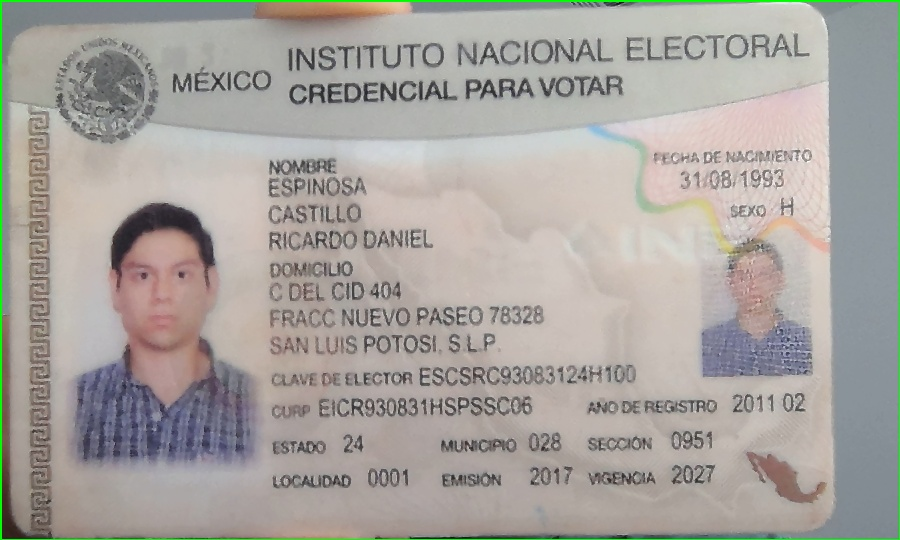

In [5]:
display(Image(filename="id_image_cropped.jpg"))

In [7]:
# Carga de la imagen recortada
image = cv2.imread("id_image_cropped.jpg")

# Convertir a escala de grises
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Aplicacion de filtro bilateral para reducir el ruido pero mantener los bordes nítidos
filtered = cv2.bilateralFilter(gray, 11, 17, 17)

# Aumente el contraste mediante la ecualización del histograma
equalized = cv2.equalizeHist(filtered)

# Treshold de la imagen para que el texto sea más nítido
_, thresh = cv2.threshold(equalized, 120, 255, cv2.THRESH_BINARY)

# Cambio del tamaño de la imagen para que los caracteres pequeños sean más legibles
resized = cv2.resize(thresh, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

# Guardar la imagen procesada para OCR
cv2.imwrite("id_image_processed.jpg", resized)

True

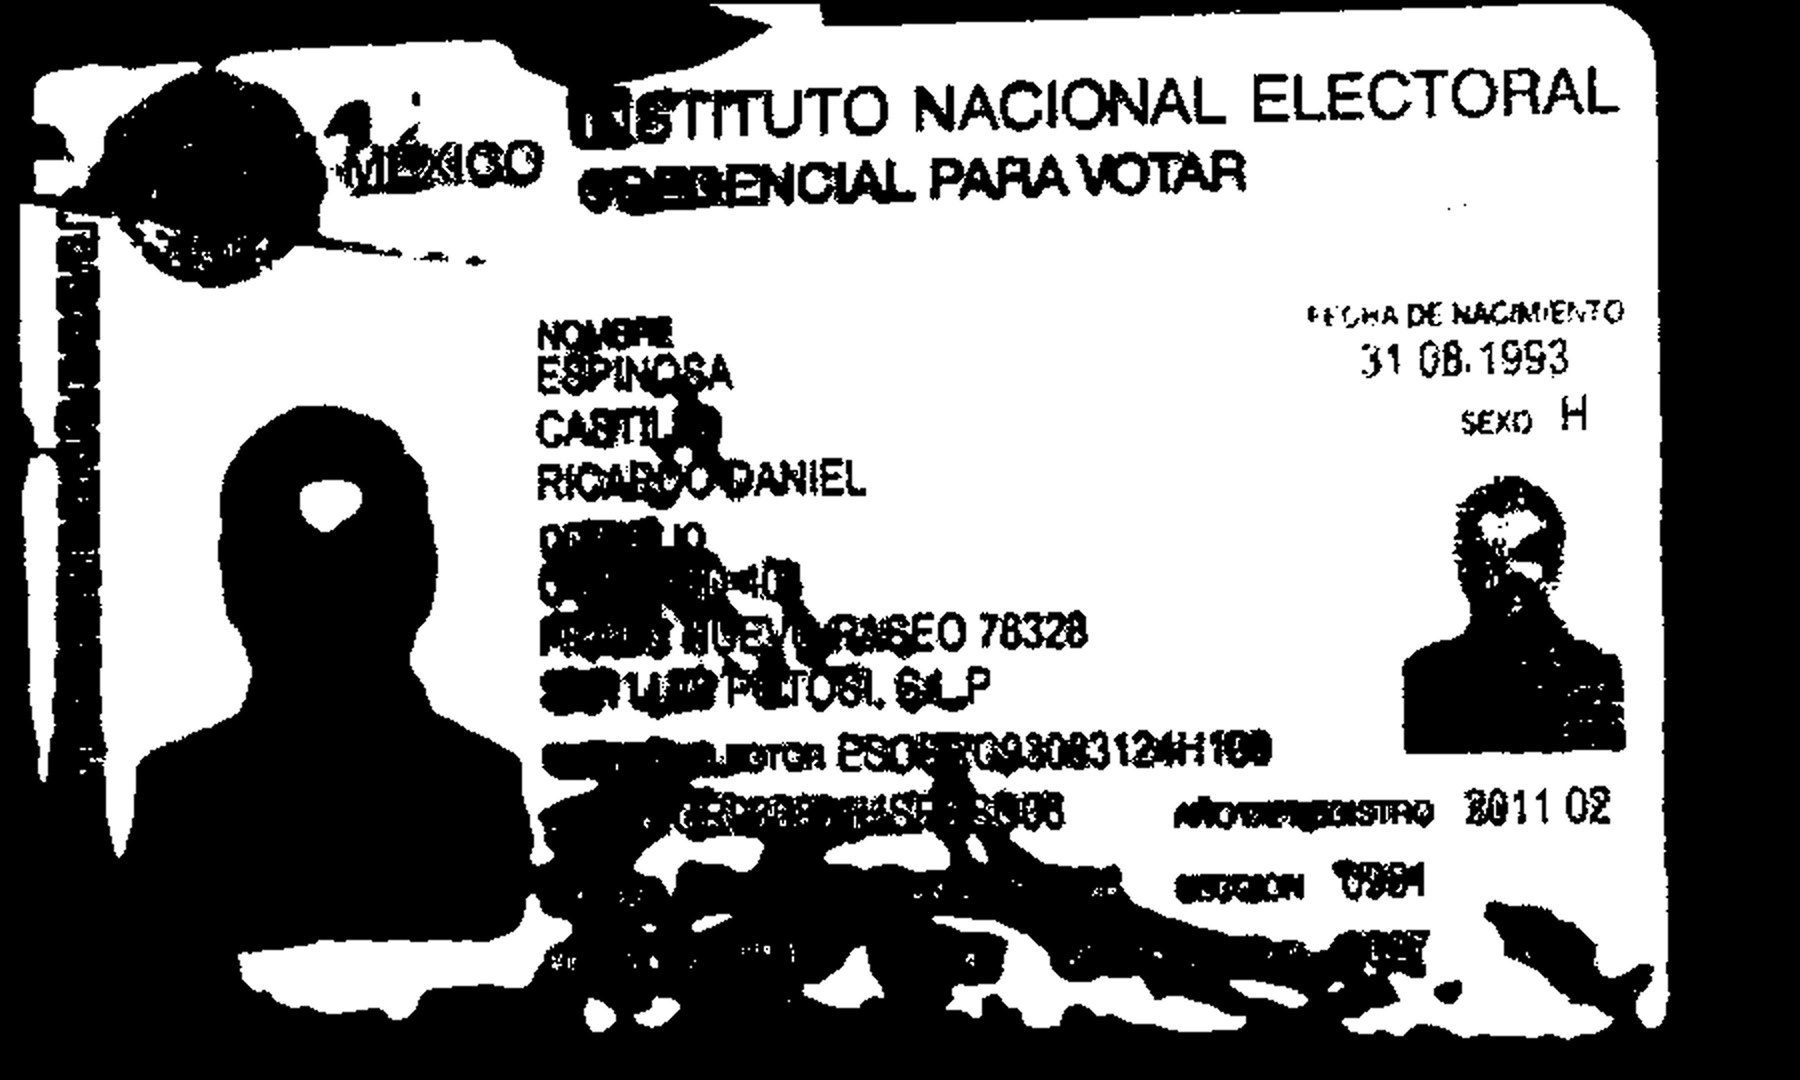

In [9]:
from IPython.display import Image, display
display(Image(filename="id_image_processed.jpg"))

In [11]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Carga de imagen
image = cv2.imread("id_image_cropped.jpg")

# Cambiar el tamaño si es necesario
# image = cv2.resize(image, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

# === 1. Eliminacion de ruido ===
image = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)

# === 2. Ajuste de contraste e iluminacion ===
image = cv2.convertScaleAbs(image, alpha=1.5, beta=10)  # alpha=contrast, beta=brightness

# === 3. Grayscale & Threshold ===
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY, 11, 2)

# === 4. Sharpening ===
kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
thresh = cv2.filter2D(thresh, -1, kernel)

# Guardando el preview
cv2.imwrite("preprocessed_id.jpg", thresh)

# === 5. Execucion de OCR  ===
custom_config = r'--oem 3 --psm 6'
text = pytesseract.image_to_string(thresh, config=custom_config, lang='spa')

print("🔍 OCR Output:")
print(text)

# === 6. Extraccion de datos ===
name_match = re.search(r'NOMBRE\s*[:\-]?\s*(.+)', text, re.IGNORECASE)
curp_match = re.search(r'CURP\s*[:\-]?\s*([A-Z0-9]{18})', text, re.IGNORECASE)
vigencia_match = re.search(r'VIGENCIA\s*[:\-]?\s*([\d/]{8,10})', text, re.IGNORECASE)

print("\n📋 Extracted INE Information:")
print("Name:", name_match.group(1).strip() if name_match else "Not found")
print("CURP:", curp_match.group(1) if curp_match else "Not found")
print("Vigencia (Expiration Date):", vigencia_match.group(1) if vigencia_match else "Not found")


🔍 OCR Output:
CTI 2.
ES Sa MÉXICO INSTITUTO NACIONAL ELECTORAL
A CREDENCIAL PARA VOTAR
| NOMBRE EI : 4
| ESPINOSA E:
; CASTILLO smomHo |
| > RICARDO DANIEL
má DONMCILIO f Y
00 CDEL CID404 CAES -
el FRACC NUEVO PASEO 78328 A, e
A SAN LUIS POTOSI SLP (Al -
Ib AT po cust otcuecron ESCSRCIIOBI124+100 A
/ / AY fi 1 A caso EICROSOB31HSPSSCOS — amoDeREGsmO 201102 | '
FITAL A e, 24 ESTADO 24 muncro 028  sroción 0951 .
vocauoro 0001 susion 2017 wena, 2027 y


📋 Extracted INE Information:
Name: EI : 4
CURP: Not found
Vigencia (Expiration Date): Not found


In [13]:
test_image = image.copy()

C:\Users\respc\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128248 (\N{CAMERA WITH FLASH}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


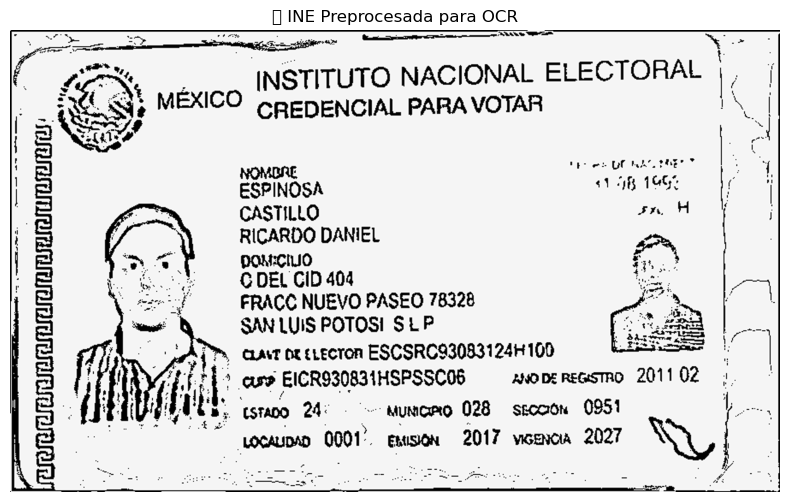

In [15]:
# 1: Conversion a escala de grises
ine_gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)

# 2: Aplicacion de CLAHE (antes de la binarizacion)
clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8))
ine_contrast = clahe.apply(ine_gray)

# 3: Adaptive Threshold
ine_thresh = cv2.adaptiveThreshold(ine_contrast, 245,
                                   cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 11, 5)

# 4: Mejorar la imagen (Tesseract se lee mejor)
ine_upscaled = cv2.resize(ine_thresh, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

# Show result
plt.figure(figsize=(10,6))
plt.imshow(ine_upscaled, cmap='gray')
plt.title("📸 INE Preprocesada para OCR")
plt.axis("off")
plt.show()

In [17]:
# Estableciendo la ruta a la carpeta tessdata que contiene spa.traineddata
os.environ['TESSDATA_PREFIX'] = r'C:\Program Files\Tesseract-OCR\tessdata'

pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

# OCR en la imagen preprocesada
custom_config = r'--oem 3 --psm 4'  # OEM 3 = default engine, PSM 6 = block of text
text = pytesseract.image_to_string(ine_upscaled, config=custom_config, lang='spa')

print("🔍 Raw OCR Output:")
print(text)

# ===== Extraccion de datos =====
lines = text.upper().split('\n')
lines = [line.strip() for line in lines if line.strip()]

# === Extraccion de NOMBRE ===
nombre = None
for i, line in enumerate(lines):
    if "NOMBRE" in line:
        name_lines = lines[i+1:i+4]  # Next 3 lines
        name_parts = [l for l in name_lines if re.match(r'^[A-ZÁÉÍÓÚÑ ]+$', l)]
        nombre = ' '.join(name_parts)
        break

# === Extraccion de CURP ===
#name_match = re.search(r'NOMBRE\s*[:\-]?\s*(.+)', text, re.IGNORECASE)
curp_match = re.search(r'CURP\s*[:\-]?\s*([A-Z0-9]{18})', text, re.IGNORECASE)

# === Extraccion de VIGENCIA (ultimo dato) ===
vigencia_pattern = re.findall(r'(?:\b\d{4}[-–]\d{4}\b|\b\d{4}\b)', text)
vigencia = vigencia_pattern[-1] if vigencia_pattern else "Not found"
#vigencia_match = re.search(r'VIGENCIA\s*[:\-]?\s*([\d/]{8,10})', text, re.IGNORECASE)

print("\n📋 Informacion de INE Extraida:")
print("Name:", nombre if nombre else "Not found")
#print("Name:", name_match.group(1).strip() if name_match else "Not found")
print("CURP:", curp_match.group(1) if curp_match else "Not found")
print("Vigencia (Expiration Date):", vigencia)
#print("Vigencia (Expiration Date):", vigencia_match.group(1) if vigencia_match else "Not found")


🔍 Raw OCR Output:
INSTITUTO NACIONAL ELECTORAL ¡, |

| 5 MÉXICO CREDENCIAL PARA VOTAR xo

: A

| NOMBRE EN Y AS OS E y
ESPINOSA A
CASTILLO mk |
RICARDO DANIEL

DOMICILIO

G DEL CiD 404

FRACC NUEVO PASEO 78328

SAN LUIS POTOSI SLP

p4 73 CLAT DE ELECTOR ESCSROS3093124H100 : '
E ]o as EICROS0831HSPSSCOS ANO DE REGISTRO 201102 ;,
IA ES, esrano 24: — murco 028 sroción 0951 bo
LOCALIDAD 0001 erusIon 2017 vcenci 2027



📋 Informacion de INE Extraida:
Name: ESPINOSA A RICARDO DANIEL
CURP: Not found
Vigencia (Expiration Date): 2027


In [19]:
import cv2
from IPython.display import Image, display
import matplotlib.pyplot as plt
import os
import pytesseract
import numpy as np
import re
import tkinter as tk
from tkinter import messagebox
from PIL import Image, ImageTk

# Configuracion de Tesseract
os.environ['TESSDATA_PREFIX'] = r'C:\Program Files\Tesseract-OCR\tessdata'
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# === OCR + Funcion de Preprocesamiento ===
def extract_ine_data(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(thresh)
    upscaled = cv2.resize(clahe, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)

    text = pytesseract.image_to_string(upscaled, config='--oem 3 --psm 4', lang='spa')
    lines = text.upper().split('\n')
    lines = [line.strip() for line in lines if line.strip()]

    # Extraccion de nombre
    name = "Not found"
    for i, line in enumerate(lines):
        if "NOMBRE" in line:
            name_lines = lines[i+1:i+4]
            name_parts = [l for l in name_lines if re.match(r'^[A-ZÁÉÍÓÚÑ ]+$', l)]
            name = ' '.join(name_parts)
            break

    # Extraccion de CURP
    curp_match = re.search(r'CURP\s*[:\-]?\s*([A-Z0-9]{18})', text)
    curp = curp_match.group(1) if curp_match else "Not found"

    # Extraccion de Vigencia
    vigencias = re.findall(r'(?:\b\d{4}[-–]\d{4}\b|\b\d{4}\b)', text)
    vigencia = vigencias[-1] if vigencias else "Not found"

    return name, curp, vigencia

# === GUI Setup ===
class IDApp:
    def __init__(self, root):
        self.root = root
        self.root.title("ID OCR App")
        self.video = cv2.VideoCapture(0)

        self.label = tk.Label(root)
        self.label.pack()

        self.capture_btn = tk.Button(root, text="📸 Capture ID", command=self.capture)
        self.capture_btn.pack(pady=10)

        self.result_label = tk.Label(root, text="", font=("Arial", 12), justify="left")
        self.result_label.pack(pady=10)

        self.confirm_btn = tk.Button(root, text="✅ Confirm & Save", command=self.confirm, state=tk.DISABLED)
        self.confirm_btn.pack(pady=10)

        self.show_frame()

    def show_frame(self):
        ret, frame = self.video.read()
        if ret:
            #frame = cv2.flip(frame, 1)

            # Definicion de cuadro guia (en porcentaje - 80% ancho, 70% alto)
            h, w, _ = frame.shape
            box_w, box_h = int(w * 0.8), int(h * 0.7)
            start_x = (w - box_w) // 2
            start_y = (h - box_h) // 2
            end_x = start_x + box_w
            end_y = start_y + box_h

            cv2.rectangle(frame, (start_x, start_y), (end_x, end_y), (0, 255, 0), 2)

            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            img = Image.fromarray(rgb)
            imgtk = ImageTk.PhotoImage(image=img)
            self.label.imgtk = imgtk
            self.label.configure(image=imgtk)
            self.current_frame = frame
        self.root.after(10, self.show_frame)

    def capture(self):
        self.name, self.curp, self.vigencia = extract_ine_data(self.current_frame)
        result_text = f"👤 Name: {self.name}\n🧬 CURP: {self.curp}\n📅 Vigencia: {self.vigencia}"
        self.result_label.config(text=result_text)
        self.confirm_btn.config(state=tk.NORMAL)

    def confirm(self):
        # You can replace this with saving to DB or file
        with open("ine_data.txt", "a", encoding="utf-8") as f:
            f.write(f"{self.name}, {self.curp}, {self.vigencia}\n")
        messagebox.showinfo("Saved", "✅ Data saved successfully!")
        self.confirm_btn.config(state=tk.DISABLED)

# === Corriendo la aplicacion ===
root = tk.Tk()
app = IDApp(root)
root.mainloop()